In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_participants
from hmpai.pytorch.utilities import set_global_seed
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.pytorch.normalization import *
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.pytorch.training import train_and_test
from torchvision.transforms import Compose
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [ ]:
set_global_seed(42)

data_paths = [DATA_PATH / "prp/stage_data_250hz_combined.nc"]

# train_percentage=100 makes test and val 100 as well
splits = split_participants(data_paths, train_percentage=60)
labels = ["negative", "t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]
# info_to_keep = ['event_name', 'participant', 'epochs', 'rt'] #TODO: Might not be present
info_to_keep = []
whole_epoch = True
subset_cond = ('condition', 'equal', 'long')
add_negative = True
skip_samples = 0 # 62
cut_samples = 0 # 63
add_pe = True

In [3]:
norm_fn = norm_mad_zscore
train_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    transform=Compose([StartJitterTransform(62, 1.0), EndJitterTransform(63, 1.0)]),
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_pe=add_pe,
)
norm_vars = get_norm_vars_from_global_statistics(train_data.statistics, norm_fn)
class_weights = train_data.statistics["class_weights"]
test_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_pe=add_pe,
)
val_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[2],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_pe=add_pe,
)

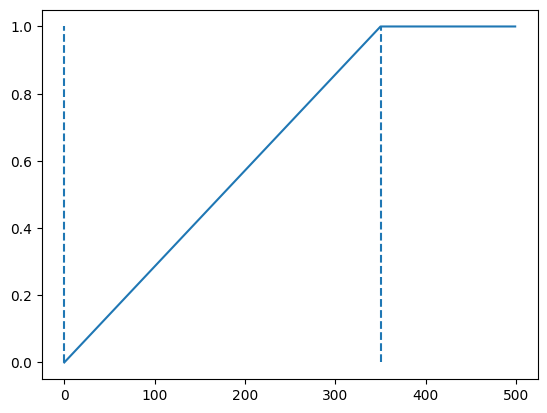

(tensor([[-1.6228e+00, -5.0158e-01, -4.7008e-01,  ...,  1.5591e+00,
          -3.4040e+00,  0.0000e+00],
         [-1.2383e+00,  5.4458e-01, -1.7714e+00,  ...,  1.3870e+00,
          -4.3259e+00,  2.8571e-03],
         [ 1.0239e+00,  1.8317e+00, -7.1900e-01,  ...,  1.1107e+00,
          -5.8492e+00,  5.7143e-03],
         ...,
         [ 9.9900e+02,  9.9900e+02,  9.9900e+02,  ...,  9.9900e+02,
           9.9900e+02,  1.0000e+00],
         [ 9.9900e+02,  9.9900e+02,  9.9900e+02,  ...,  9.9900e+02,
           9.9900e+02,  1.0000e+00],
         [ 9.9900e+02,  9.9900e+02,  9.9900e+02,  ...,  9.9900e+02,
           9.9900e+02,  1.0000e+00]]),
 tensor([[9.7047e-01, 3.7315e-08, 4.0750e-03,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [9.6928e-01, 2.0931e-08, 3.4494e-03,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [9.6810e-01, 1.2279e-08, 2.9245e-03,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [1.0000e+00, 0.0000e+00, 0.0000e+0

In [12]:
train_data.__getitem__(8)

In [4]:
config = {
    "n_channels": 64,
    "n_classes": len(labels),
    "n_mamba_layers": 5,
    "use_pointconv_fe": True,
    "spatial_feature_dim": 128,
    "use_conv": True,
    "conv_kernel_sizes": [3],
    "conv_in_channels": [128],
    "conv_out_channels": [256],
    "conv_concat": True,
    "use_pos_enc": True,
}
model = build_mamba(config)
train_and_test(
    model,
    train_data,
    test_data,
    val_data,
    logs_path=Path("../logs/"),
    workers=8,
    batch_size=32,
    labels=labels,
    lr=0.0001,
    do_spectral_decoupling=False,
    use_class_weights=False,
    class_weights=class_weights,
    whole_epoch=True,
    epochs=20,
)

  0%|          | 0/199 [00:00<?, ? batch/s]

  0%|          | 0/199 [00:00<?, ? batch/s]

KeyboardInterrupt: 